# 第五章：对未标记数据进行预训练

In [98]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.5.1
tensorflow version: 2.18.0


## 5.1 评估生成文本模型

In [ ]:
import torch
from previous_chapters import GPTModel
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

GPT_CONFIG_124M = {
    "vocab_size": len(tokenizer),   # Vocabulary size
    "context_length": 128, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [ ]:
# import tiktoken
from transformers import BertTokenizer
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, max_length=1024, truncation=True)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer,skip_special_tokens=True):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist(), skip_special_tokens=skip_special_tokens, clean_up_tokenization_spaces=True)

start_context = "每一次努力都让你感动"
# tokenizer = tiktoken.get_encoding("gpt2")
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每 一 次 努 力 都 让 你 可 以 在 五 分 钟 内 告 诉 你 因 为 他 已 经 留 下 来 了 ！ 我 们 其 他 人 要 么 随


In [101]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/GavinHome/LLMs-from-scratch-zh/main/ch02/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [125]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.80
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(42)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [126]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])

Validation loader:
torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 128]) torch.Size([2, 128])


In [127]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 2048
Validation tokens: 512
All tokens: 2560


In [128]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(42) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.140604615211487
Validation loss: 10.117958068847656


## 5.2 训练一个LLM

In [130]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [132]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="每一次努力都让你感动", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 8.846, Val loss 9.099
Ep 1 (Step 000005): Train loss 7.176, Val loss 7.494
每 一 次 努 力 都 让 你 感 动 的 的
Ep 2 (Step 000010): Train loss 6.057, Val loss 6.355
Ep 2 (Step 000015): Train loss 5.502, Val loss 5.795
每 一 次 努 力 都 让 你 感 动 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 ， 我 的 的 的 的 的 的 的 的 的 的 的 ，
Ep 3 (Step 000020): Train loss 5.090, Val loss 5.556
每 一 次 努 力 都 让 你 感 动 的 ， 我 的 ， 我 的 ， 我 的
Ep 4 (Step 000025): Train loss 5.161, Val loss 6.850
Ep 4 (Step 000030): Train loss 4.289, Val loss 5.354
每 一 次 努 力 都 让 你 感 动 他 是 一 个 廉 价 的 作 品 他 的
Ep 5 (Step 000035): Train loss 3.457, Val loss 4.963
每 一 次 努 力 都 让 你 感 动 我 听 说 是 一 个 斯 伯 恩 的 我 听 说 说 他 是 我 们 ， 我 的 我 ， 当 我 ，
Ep 6 (Step 000040): Train loss 2.490, Val loss 4.708
Ep 6 (Step 000045): Train loss 2.282, Val loss 4.389
每 一 次 努 力 都 让 你 感 动 我 ， 我 的 模 特 劳 德 我 ， 想 要 更 好 地 了 解 他 。 我 希 望 你 能 告 诉 我 这 一 个 秘 密 了 绘 画 ， 正 如 斯 温 太 太 所 预
Ep 7 (Step 000050): Train loss 1.646, Val loss 4.157
Ep 7 (Step 

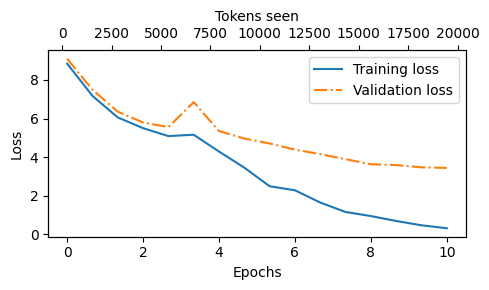

In [133]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [144]:
model.to("cpu")
model.eval()

# tokenizer = tiktoken.get_encoding("gpt2")
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("每一次努力都让你感动", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每 一 次 努 力 都 让 你 感 动 在 五 分 钟 内 告 诉 你 因 为 他 已 经 留 下 来 了 ！ 我 们 其 他 人 要 么 随 波 逐 流 ， 要 么 沉 没 ， 但 他 高 高 在 上 如 你 所 说 ，


In [135]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [146]:
torch.manual_seed(42)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("每一次努力都让你", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每 一 次 努 力 都 让 你 说 是 且 当 时 停 在 吉 斯 温 太 那 绘 画 相 提 并 论 。 于 是 既 然 他 的 决 定 满 足 而 果 仰 头 看 穿 驴 时 都 散 他 的 心 我 是 多 么 惊 讶


In [60]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [84]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();